In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("incl/")

import ELPH_utils

In [2]:
runs = ELPH_utils.load_runs()

n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)

100 loaded with n_kmax = 80


runs[0] shape:  (80, 400)


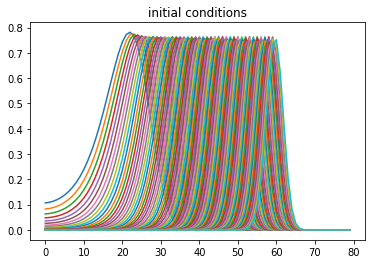

In [3]:
print('runs[0] shape: ', runs[0].shape)

for k in range(n_runs):
    plt.plot(runs[k][:,0])

plt.title('initial conditions')
plt.show()

rdim:  20
n_VAR_steps:  20
state shape:  (400, 39900)
target shape:  (20, 39900)
weights shape:  (400, 20)


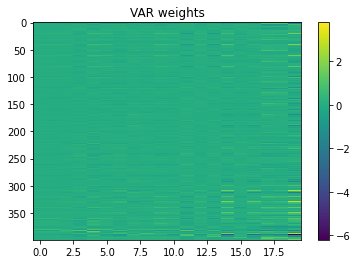

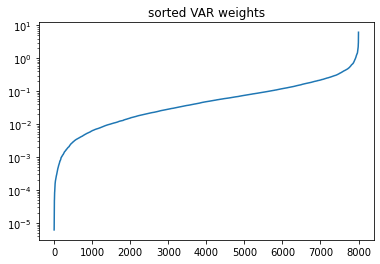

In [4]:
from ELPH_VAR import SVDVAR
    
VAR = SVDVAR(runs, rdim=10, n_VAR_steps=5)
VAR.train(alpha=10**-2.7, rdim = 20, n_VAR_steps = 20, method='ridge')
VAR.print_status()

plt.imshow(VAR.w, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('VAR weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(VAR.w))))
plt.title('sorted VAR weights')
plt.show()

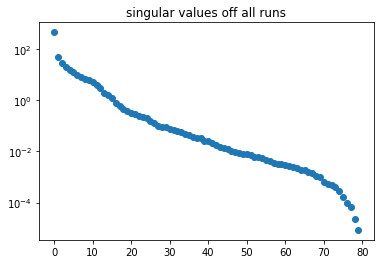

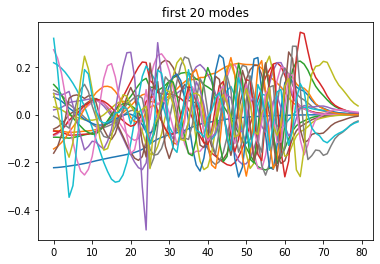

In [5]:
plt.semilogy(VAR.S, 'o')
plt.title('singular values off all runs')
plt.show()
 
for l in range(VAR.rdim):
  plt.plot(VAR.U[:,l],  label='Uhat_'+str(l))
plt.title('first ' + str(VAR.rdim) + ' modes')
plt.show()

In [22]:
train_kwargs = {'alpha':10**-2.7, 'rdim':20, 'n_VAR_steps':20, 'intercept':True, 'standardize':True}
score_kwargs = {'norm':'max', 'errSVD':False}

mean_score, scores = ELPH_utils.get_KFold_CV_scores(VAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)

print('mean score: ', mean_score)
print('scores: ', scores)

mean score:  0.00839280148274174
scores:  [0.007574547487235661, 0.008826140534488597, 0.008254176717754805, 0.009090523482987157, 0.008218619191242487]


In [7]:
def get_BO_score(aExp, rdim, n_VAR_steps):
    alpha = 10.0**aExp
    rdim = int(rdim)
    n_VAR_steps = int(n_VAR_steps)
    
    train_kwargs = {'alpha':alpha, 'rdim':rdim, 'n_VAR_steps':n_VAR_steps}
    score_kwargs = {'norm':'fro', 'errSVD':False}
    
    m,s = ELPH_utils.get_KFold_CV_scores(VAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
    return -1.*m - 1.*np.std(s)


# print(KFCV_score(-6,3,5))

from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'aExp': [-6, -1], 'rdim': [1,20], 'n_VAR_steps': [1,20]}

optimizer = BayesianOptimization(
    f=get_BO_score,
    pbounds=pbounds,
    random_state=816,
)

# optimizer.maximize(init_points=10, n_iter=100)

rdim:  20
n_VAR_steps:  20
state shape:  (400, 37620)
target shape:  (20, 37620)
weights shape:  (400, 20)
VAR error:  0.0078527623758749


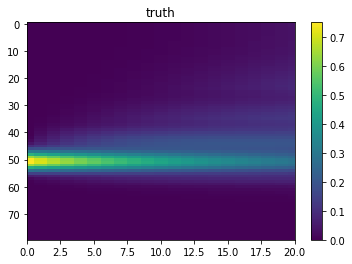

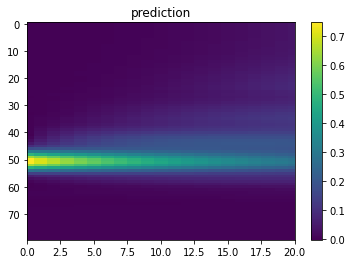

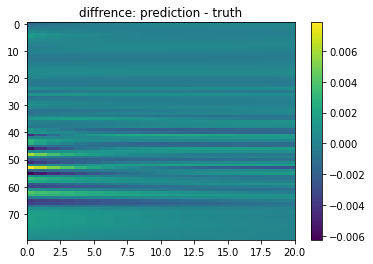

VAR error compared to SVD approximated run:  0.0018440229426849308


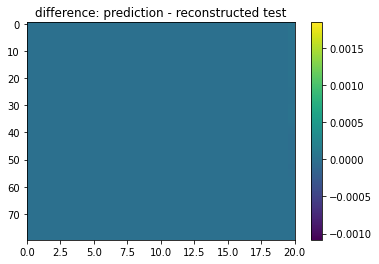

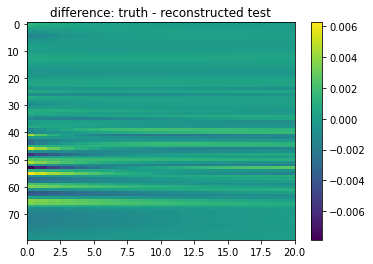

In [8]:
train_runs = runs.copy()
test_run = train_runs.pop(67)

VAR.load_runs(train_runs)
VAR.train(alpha=10**-2.7, rdim=20, n_VAR_steps=20, full_hist=True)

VAR.print_status()

print('VAR error: ', VAR.get_error(test_run, norm='max') )

pred = VAR.predict_single_run(test_run)


xmax = 20

plt.imshow(test_run, aspect='auto', interpolation='None')
plt.colorbar()
plt.title('truth')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred, aspect='auto', interpolation='None')
plt.colorbar()
plt.title('prediction')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run, aspect='auto', interpolation='None')
plt.colorbar()
plt.title('diffrence: prediction - truth')
plt.xlim(0,xmax)
plt.show()


print('VAR error compared to SVD approximated run: ', VAR.get_error(test_run, norm='max', errSVD=True) )
approx_test_run = VAR.Uhat @ VAR.Uhat.T @ test_run

plt.imshow(pred-approx_test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - reconstructed test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(test_run-approx_test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: truth - reconstructed test')
plt.xlim(0,xmax)
plt.show()